In [5]:
import os
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image, ImageOps
from datasets import load_metric
from torch.utils.data import Dataset
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

from ultralytics import YOLO

In [6]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class TextRecognizePipeline:
    
    def __init__(self):
        self.ocr_processor = TrOCRProcessor.from_pretrained("raxtemur/trocr-base-ru")
        self.ocr_model = VisionEncoderDecoderModel.from_pretrained("../../models/text_recognizer/checkpoint-1107/", local_files_only=True).to(device)
        self.detection_model = YOLO("../../models/new_text_detector/best_1024.pt").to(device)
        
        # Set special tokens used for creating the decoder_input_ids from the labels.
        self.ocr_model.config.decoder_start_token_id = self.ocr_processor.tokenizer.cls_token_id
        self.ocr_model.config.pad_token_id = self.ocr_processor.tokenizer.pad_token_id
        # Set Correct vocab size.
        self.ocr_model.config.vocab_size = self.ocr_model.config.decoder.vocab_size
        self.ocr_model.config.eos_token_id = self.ocr_processor.tokenizer.sep_token_id
        
        self.ocr_model.config.max_length = 64
        self.ocr_model.config.early_stopping = True
        self.ocr_model.config.no_repeat_ngram_size = 3
        self.ocr_model.config.length_penalty = 2.0
        self.ocr_model.config.num_beams = 4
    
    def get_detections_and_crop_boxes(self, img_list: list[Image]) -> list[Image]:
        
        def sort_bbox_by_y(bbox_list):
            sorted_bbox = sorted(bbox_list, key=lambda bbox: bbox[3])  # Сортировка по координате y
            return sorted_bbox
        
        result = []
        for predict, image in zip(self.detection_model.predict(img_list), img_list):
            bboxes = predict.boxes.xyxy.cpu().tolist()
            sorted_bboxes = sort_bbox_by_y(bboxes)
            for box in sorted_bboxes:
                cropped_image = image.crop(box)
                result.append(cropped_image)
        return result
    
    def get_ocr_predictions(self, img_list: list[Image]) -> list[str]:
        pixel_values = self.ocr_processor(img_list, return_tensors="pt").pixel_values.to(device)
        generated_ids = self.ocr_model.generate(pixel_values)
        generated_text = self.ocr_processor.batch_decode(generated_ids, skip_special_tokens=True)
        return generated_text
    
    def recognize(self, img_list: list[Image]) -> list[str]:
        cropped_images = self.get_detections_and_crop_boxes(img_list)
        recognized_text = self.get_ocr_predictions(cropped_images)
        return recognized_text

In [10]:
import pathlib

def get_rand_image():
    path = pathlib.Path("../../data/raw/Распознавание текстов/Уставные грамоты в jpg (Просветов)")
    return np.random.choice(list(path.iterdir()))


ocr_pipeline = TextRecognizePipeline()

In [12]:
img = Image.open(get_rand_image())
img = ImageOps.exif_transpose(img)
img.show()

0: 1024x736 20 texts, 21.0ms
Speed: 4.0ms preprocess, 21.0ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 736)


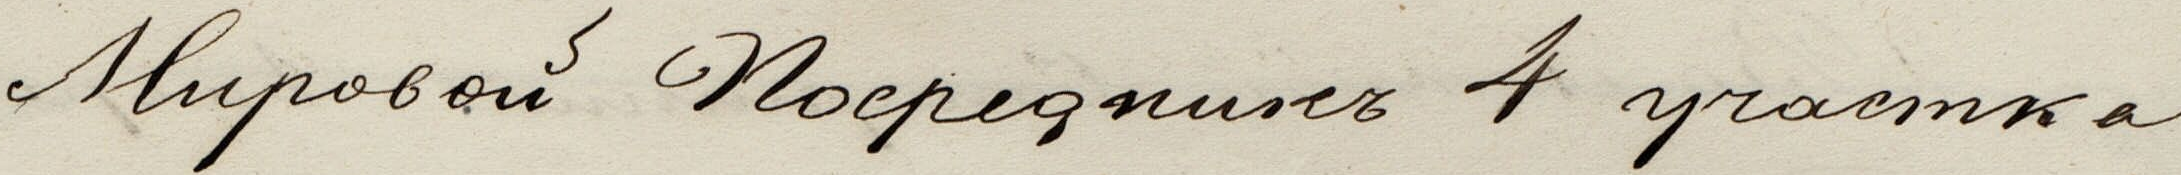

In [15]:
ocr_pipeline.get_detections_and_crop_boxes([img])[0]

In [16]:
recognized_text = ocr_pipeline.recognize([img])

0: 1024x736 20 texts, 21.0ms
Speed: 4.0ms preprocess, 21.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 736)


In [17]:
recognized_text

['Мировой Посредникъ 4 участка',
 'Игнатьевъ. На подлинномъ',
 'чать Осташковскаго Мирова',
 'го Посредника 4 участка. При',
 'семъ находился Управляющiй',
 'Тверскою Удельного Конторое',
 'А. Уманецъ. При этомъ нахо',
 'дились крестьяне дер. Карякъ',
 'на Андрей Степановъ, Гаври',
 'ла Васильевъ и Повъ федоров',
 'а равно и посторонния добро',
 'советные люди крестьяне дерев',
 'Ревянина Лука Ивановъ, Ва',
 'симiй Васильевъ и Голенищева',
 'Захаръ Евстигнеевъ, а вместо ихъ',
 'неграмотных по ихъ личной',
 'просьбе крестьянинъ деревни',
 'Захарина Андрей Ива',
 'новъ руку приложилъ. При',
 'этомъ находился Давыдовскiй']

In [ ]:
path_to_checkpoint = "../../models/text_recognizer/checkpoint-1107/"

# Инициализируем распознавание текста
processor = TrOCRProcessor.from_pretrained("raxtemur/trocr-base-ru")
model = VisionEncoderDecoderModel.from_pretrained(path_to_checkpoint, local_files_only=True)
model.to(device)

In [4]:
text_detector = YOLO("../../models/new_text_detector/best_1024.pt").to(device)

In [21]:


# img = Image.open(r"../../data/raw/Распознавание текстов/Уставные грамоты в jpg (Просветов)/11227024_doc1.jpg")
img = Image.open(get_rand_image())
img = ImageOps.exif_transpose(img)

res = text_detector.predict([img])

# Process results list
for result in res:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen

0: 1024x768 24 texts, 23.2ms
Speed: 5.5ms preprocess, 23.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9534, 0.9532, 0.9523, 0.9519, 0.9504, 0.9502, 0.9485, 0.9460, 0.9447, 0.9446, 0.9442, 0.9423, 0.9407, 0.9401, 0.9388, 0.9377, 0.9363, 0.9341, 0.9272, 0.9268, 0.9246, 0.9179, 0.9057, 0.8957], device='cuda:0')
data: tensor([[1.0748e+03, 3.2288e+03, 3.2465e+03, 3.4166e+03, 9.5341e-01, 0.0000e+00],
        [1.0803e+03, 3.1040e+03, 3.2587e+03, 3.2751e+03, 9.5324e-01, 0.0000e+00],
        [1.1057e+03, 1.8397e+03, 3.2291e+03, 2.0472e+03, 9.5235e-01, 0.0000e+00],
        [1.0423e+03, 5.0129e+02, 3.2115e+03, 7.5331e+02, 9.5191e-01, 0.0000e+00],
        [1.0960e+03, 2.5498e+03, 3.2448e+03, 2.7314e+03, 9.5035e-01, 0.0000e+00],
        [1.0737e+03, 2.3964e+03, 3.1750e+03, 2.6